In [1]:
!git clone https://github.com/aubinbnf/Speech-Emotion-Recognition.git
%cd Speech-Emotion-Recognition
# !git branch -r
# !git switch TESS
# !git switch simon
# !git status
# !git pull TESS



Cloning into 'Speech-Emotion-Recognition'...
remote: Enumerating objects: 21801, done.
remote: Counting objects: 100% (4353/4353), done.
remote: Compressing objects: 100% (4334/4334), done.
remote: Total 21801 (delta 29), reused 4310 (delta 11), pack-reused 17448 (from 5)
Receiving objects: 100% (21801/21801), 1.00 GiB | 16.00 MiB/s, done.
Resolving deltas: 100% (404/404), done.
Updating files: 100% (4954/4954), done.
/content/Speech-Emotion-Recognition


In [2]:
%ls
%cd Speech-Emotion-Recognition



 CNN/        CNNBLSTM_ATTENTION/  'data management'/   EXTRAS_MODELS/   PARALELLECNN/         VGG/
 CNNBLSTM/   CNNLSTM_ATTENTION/    dataset/            LSTM/           'Results and plots'/
[Errno 2] No such file or directory: 'Speech-Emotion-Recognition'
/content/Speech-Emotion-Recognition


In [ ]:
#nouvelle data augmentation#  mais max ram
#!/usr/bin/env python3

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# ==========================
# GPU CONFIGURATION
# ==========================
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU:", physical_devices[0].name)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# ==========================
# DATA LOADING
# ==========================
dataset_dir = "/content/Speech-Emotion-Recognition/DATASET FINAL"  # Adjust path
emotion_map = {
    "angry": 0,
    "sad": 1,
    "surprise": 2,
    "neutral": 3,
    "happy": 4,
    "fearful": 5,
    "disgust": 6
}

images, labels = [], []

# List all image files in the dataset directory
all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]

# Select a random subset (e.g., 70%) of the dataset
subset_size = int(0.7 * len(all_files))
selected_files = np.random.choice(all_files, size=subset_size, replace=False)

for file_name in selected_files:
    file_path = os.path.join(dataset_dir, file_name)
    img = Image.open(file_path).convert("RGB").resize((224, 224))
    images.append(np.array(img))

    # Extract emotion label from the filename
    parts = file_name.split("_")
    if len(parts) >= 2:
        emotion = parts[1].lower()
        if emotion in emotion_map:
            label_raw = emotion_map[emotion]
        else:
            print(f"Skipping {file_name}: Unknown emotion '{emotion}'.")
            continue
    else:
        print(f"Skipping {file_name}: Incorrect format.")
        continue

    labels.append(label_raw)

images = np.array(images) / 255.0
labels = np.array(labels)

# Number of classes (emotions)
num_classes = len(emotion_map)

labels_one_hot = to_categorical(labels, num_classes=num_classes)
# Split the dataset into 70% for training and 30% for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# ==========================
# DATA AUGMENTATION FOR SPECTROGRAMS
# ==========================
def augment_spectrogram(spectrogram):
    """Applies data augmentation to spectrogram images."""
    augmented = spectrogram.copy()

    # Add random noise
    noise = np.random.normal(0, 0.02, spectrogram.shape)
    augmented += noise
    augmented = np.clip(augmented, 0, 1)

    # Time shift (roll the image horizontally)
    shift = np.random.randint(-20, 20)
    augmented = np.roll(augmented, shift, axis=1)

    # Time masking
    time_mask_size = np.random.randint(0, 20)
    time_mask_start = np.random.randint(0, augmented.shape[1] - time_mask_size)
    augmented[:, time_mask_start:time_mask_start + time_mask_size] = 0

    # Frequency masking
    freq_mask_size = np.random.randint(0, 20)
    freq_mask_start = np.random.randint(0, augmented.shape[0] - freq_mask_size)
    augmented[freq_mask_start:freq_mask_start + freq_mask_size, :] = 0

    return augmented

# Apply augmentation to training set
X_train_augmented = np.array([augment_spectrogram(img) for img in X_train])

# ==========================
# MODEL FUNCTIONS
# ==========================
def create_vgg19_model():
    base_model = VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:12]:
        layer.trainable = False
    model = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# ==========================
# EXPERIMENTAL SETUP
# ==========================
model = create_vgg19_model()
model.compile(optimizer=optimizers.Adam(5e-5),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

callbacks = [
    ModelCheckpoint("VGG19_best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
    ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.95, min_lr=0.000001),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

history = model.fit(
    X_train_augmented, y_train,
    epochs=40,
    shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")




Exception ignored in: <function _xla_gc_callback at 0x7f977c3757e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Using GPU: /physical_device:GPU:0


KeyboardInterrupt: 

In [ ]:
#reduce max ram avec overfit

#!/usr/bin/env python3


import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import librosa
from PIL import Image
import matplotlib.pyplot as plt
import random
import gc

# ==========================
# MEMORY OPTIMIZATION
# ==========================
def clear_memory():
    """Libère la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

# ==========================
# DATA GENERATOR
# ==========================
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size=16, dim=(224, 224),
                 n_channels=3, n_classes=7, shuffle=True, is_training=True):
        self.file_list = file_list
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.is_training = is_training
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_list[k] for k in indexes]
        X, y = self.__data_generation(batch_files, indexes)
        return X, y

    def __data_generation(self, batch_files, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, file_name in enumerate(batch_files):
            img = Image.open(file_name).convert("RGB").resize(self.dim)
            img_array = np.array(img) / 255.0

            if self.is_training and random.random() < 0.5:
                img_array = augment_spectrogram(img_array)

            X[i,] = img_array
            y[i] = self.labels[indexes[i]]

        return X, y

# ==========================
# DATA AUGMENTATION
# ==========================
def augment_spectrogram(spectrogram, p=0.5):
    """Version simplifiée de l'augmentation pour économiser la mémoire"""
    augmented = spectrogram.copy()

    # Appliquer seulement les augmentations les plus efficaces
    if random.random() < p:
        # Gaussian noise
        noise = np.random.normal(0, 0.01, spectrogram.shape)
        augmented = np.clip(augmented + noise, 0, 1)

    if random.random() < p:
        # Time masking
        t0 = np.random.randint(0, spectrogram.shape[1] - 20)
        augmented[:, t0:t0 + 20] = 0

    return augmented

# ==========================
# MAIN TRAINING LOOP
# ==========================
def main():
    # Configuration
    dataset_dir = "/content/Speech-Emotion-Recognition/DATASET FINAL"
    batch_size = 16  # Réduit la taille du batch
    emotion_map = {
        "angry": 0, "sad": 1, "surprise": 2, "neutral": 3,
        "happy": 4, "fearful": 5, "disgust": 6
    }

    # Préparer la liste des fichiers
    file_list = []
    labels = []

    for file_name in os.listdir(dataset_dir):
        if file_name.endswith(".png"):
            emotion = file_name.split("_")[1].lower()
            if emotion in emotion_map:
                file_list.append(os.path.join(dataset_dir, file_name))
                label = emotion_map[emotion]
                labels.append(to_categorical(label, num_classes=len(emotion_map)))

    # Split les données
    train_files, test_files, train_labels, test_labels = train_test_split(
        file_list, labels, test_size=0.2, random_state=42
    )

    train_files, val_files, train_labels, val_labels = train_test_split(
        train_files, train_labels, test_size=0.2, random_state=42
    )

    # Créer les générateurs
    train_generator = DataGenerator(
        train_files, train_labels, batch_size=batch_size, is_training=True
    )
    val_generator = DataGenerator(
        val_files, val_labels, batch_size=batch_size, is_training=False
    )
    test_generator = DataGenerator(
        test_files, test_labels, batch_size=batch_size, is_training=False
    )

    # Créer le modèle
    clear_memory()
    base_model = VGG19(
        weights='imagenet',
        pooling='avg',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    for layer in base_model.layers[:12]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Dense(256, activation='relu'),  # Réduit la taille des couches
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(len(emotion_map), activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(5e-5),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            "best_model.keras",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max"
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            patience=2,
            factor=0.95,
            min_lr=0.000001
        )
        # EarlyStopping(
        #     monitor="val_loss",
        #     patience=5,
        #     restore_best_weights=True
        # )
    ]

  # Entraînement
    history = model.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
        callbacks=callbacks
    )

    # Évaluation
    print("\nEvaluating model on test set...")
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Sauvegarder les courbes d'apprentissage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.close()

if __name__ == "__main__":
    main()

Epoch 1/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 32s 209ms/step - accuracy: 0.1997 - loss: 2.5114 - val_accuracy: 0.1205 - val_loss: 3.9264 - learning_rate: 5.0000e-05
Epoch 2/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 200ms/step - accuracy: 0.2468 - loss: 2.3553 - val_accuracy: 0.1920 - val_loss: 6.4231 - learning_rate: 5.0000e-05
Epoch 3/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.3012 - loss: 2.0316 - val_accuracy: 0.1920 - val_loss: 7.3168 - learning_rate: 5.0000e-05
Epoch 4/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.3355 - loss: 1.9946 - val_accuracy: 0.1652 - val_loss: 7.7457 - learning_rate: 5.0000e-05
Epoch 5/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 204ms/step - accuracy: 0.3297 - loss: 1.9257 - val_accuracy: 0.2299 - val_loss: 6.8661 - learning_rate: 4.7500e-05
Epoch 6/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 39s 192ms/step - accuracy: 0.3716 - loss: 1.8210 - val_accuracy: 0.1786 - val_loss: 9.5677 - learning_rate: 4.7500e-05
Epoch 7/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 19

In [ ]:
#!/usr/bin/env python3 reduce max ram sans overfit

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import librosa
from PIL import Image
import matplotlib.pyplot as plt
import random
import gc

# ==========================
# MEMORY OPTIMIZATION
# ==========================
def clear_memory():
    """Libère la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

# ==========================
# DATA GENERATOR
# ==========================
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size=16, dim=(224, 224),
                 n_channels=3, n_classes=7, shuffle=True, is_training=True):
        self.file_list = file_list
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.is_training = is_training
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_list[k] for k in indexes]
        X, y = self.__data_generation(batch_files, indexes)
        return X, y

    def __data_generation(self, batch_files, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, file_name in enumerate(batch_files):
            img = Image.open(file_name).convert("RGB").resize(self.dim)
            img_array = np.array(img) / 255.0

            if self.is_training and random.random() < 0.7:  # Augmenté à 0.7
                img_array = augment_spectrogram(img_array)

            X[i,] = img_array
            y[i] = self.labels[indexes[i]]

        return X, y

# ==========================
# DATA AUGMENTATION
# ==========================
def augment_spectrogram(spectrogram, p=0.7):
    """Applique des augmentations sur un spectrogramme."""
    augmented = spectrogram.copy()

    if random.random() < p:
        noise = np.random.normal(0, 0.02, spectrogram.shape)  # Bruit augmenté
        augmented = np.clip(augmented + noise, 0, 1)

    if random.random() < p:
        t0 = np.random.randint(0, spectrogram.shape[1] - 30)  # Masquage temporel
        augmented[:, t0:t0 + 30] = 0

    if random.random() < p:
        f0 = np.random.randint(0, spectrogram.shape[0] - 30)
        augmented[f0:f0 + 30, :] = 0  # Masquage fréquentiel augmenté

    return augmented

# ==========================
# MAIN TRAINING LOOP
# ==========================
def main():
    # Configuration
    dataset_dir = "/content/Speech-Emotion-Recognition/DATASET FINAL"
    batch_size = 16
    emotion_map = {
        "angry": 0, "sad": 1, "surprise": 2, "neutral": 3,
        "happy": 4, "fearful": 5, "disgust": 6
    }

    # Préparer la liste des fichiers
    file_list = []
    labels = []

    for file_name in os.listdir(dataset_dir):
        if file_name.endswith(".png"):
            emotion = file_name.split("_")[1].lower()
            if emotion in emotion_map:
                file_list.append(os.path.join(dataset_dir, file_name))
                label = emotion_map[emotion]
                labels.append(to_categorical(label, num_classes=len(emotion_map)))

    # Split les données
    train_files, test_files, train_labels, test_labels = train_test_split(
        file_list, labels, test_size=0.2, random_state=42
    )

    train_files, val_files, train_labels, val_labels = train_test_split(
        train_files, train_labels, test_size=0.2, random_state=42
    )

    # Créer les générateurs
    train_generator = DataGenerator(
        train_files, train_labels, batch_size=batch_size, is_training=True
    )
    val_generator = DataGenerator(
        val_files, val_labels, batch_size=batch_size, is_training=False
    )
    test_generator = DataGenerator(
        test_files, test_labels, batch_size=batch_size, is_training=False
    )

    # Créer le modèle
    clear_memory()
    base_model = VGG19(
        weights='imagenet',
        pooling='avg',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    for layer in base_model.layers[:15]:  # Plus de couches gelées
        layer.trainable = False

    model = Sequential([
        base_model,
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(emotion_map), activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(1e-5),  # LR réduit
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = [
        ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
        ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.95, min_lr=0.000001)
    ]

    # Entraînement
    history = model.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
        callbacks=callbacks
    )

    # Évaluation
    print("\nEvaluating model on test set...")
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Sauvegarder les courbes d'apprentissage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.close()

if __name__ == "__main__":
    main()


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 29s 170ms/step - accuracy: 0.1457 - loss: 5.9606 - val_accuracy: 0.2098 - val_loss: 4.7613 - learning_rate: 1.0000e-05
Epoch 2/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 34s 158ms/step - accuracy: 0.2038 - loss: 5.4991 - val_accuracy: 0.3103 - val_loss: 4.6640 - learning_rate: 1.0000e-05
Epoch 3/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.2221 - loss: 5.3327 - val_accuracy: 0.4241 - val_loss: 4.4323 - learning_rate: 1.0000e-05
Epoch 4/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.2409 - loss: 5.2308 - val_accuracy: 0.4152 - val_loss: 4.3378 - learning_rate: 1.0000e-05
Epoch 5/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 0.2713 - loss: 5.0318 - val_accuracy: 0.4420 - val_loss: 4.2735 - learning_rate: 1.0000e-05
Epoch 6/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - accuracy: 0.2845 - loss: 4.9095 - val_accuracy: 0.5067 - val_loss: 4.0144 - learning_rate: 1.0000e-05
Epoch 7/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - 

In [10]:
#new code DATA AUDIO AUGM AVEC ANCIEN PARAMAETRE


import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import librosa
from PIL import Image
import matplotlib.pyplot as plt
import random
import gc

# ==========================
# MEMORY OPTIMIZATION
# ==========================
def clear_memory():
    """Libère la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

# ==========================
# DATA GENERATOR
# ==========================
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size=16, dim=(224, 224),
                 n_channels=3, n_classes=7, shuffle=True, is_training=True):
        self.file_list = file_list
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.is_training = is_training
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_list[k] for k in indexes]
        X, y = self.__data_generation(batch_files, indexes)
        return X, y

    def __data_generation(self, batch_files, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, file_name in enumerate(batch_files):
            img = Image.open(file_name).convert("RGB").resize(self.dim)
            img_array = np.array(img) / 255.0

            # COMMENTED OUT THE AUGMENTATION PART
            # if self.is_training and random.random() < 0.7:  # Augmenté à 0.7
            #     img_array = augment_spectrogram(img_array)

            X[i,] = img_array
            y[i] = self.labels[indexes[i]]

        return X, y

# ==========================
# MAIN TRAINING LOOP
# ==========================
def main():
    # Configuration
    dataset_dir = "/content/Speech-Emotion-Recognition/dataset"
    batch_size = 16
    emotion_map = {
        "angry": 0, "sad": 1, "surprise": 2, "neutral": 3,
        "happy": 4, "fearful": 5, "disgust": 6
    }

    # Préparer la liste des fichiers
    file_list = []
    labels = []

    # Handling the files to distinguish augmented and non-augmented ones
    for file_name in os.listdir(dataset_dir):
        if file_name.endswith(".png"):
            # Split to get the emotion and remove the "aug" part for labeling
            emotion = file_name.split("_")[1].lower()
            if emotion in emotion_map:
                # Only add the base name of the file for labeling (ignore 'aug')
                file_list.append(os.path.join(dataset_dir, file_name))
                label = emotion_map[emotion]
                labels.append(to_categorical(label, num_classes=len(emotion_map)))

    # Split the data: training with augmentation, validation and test without augmentation
    aug_files = [f for f in file_list if 'aug' in f]  # Augmented files
    non_aug_files = [f for f in file_list if 'aug' not in f]  # Non-augmented files

    # Randomly shuffle augmented files for training
    random.shuffle(aug_files)

    print(f"Number of files: {len(file_list)}")
    print(f"Number of labels: {len(labels)}")

    # Create the corresponding labels for augmented and non-augmented files
    aug_labels = [labels[file_list.index(f)] for f in aug_files]
    non_aug_labels = [labels[file_list.index(f)] for f in non_aug_files]

    # Now we split augmented data for training, and non-augmented data for validation and test
    train_files, test_files, train_labels, test_labels = train_test_split(
        aug_files, aug_labels, test_size=0.2, random_state=42
    )

    train_files, val_files, train_labels, val_labels = train_test_split(
        train_files, train_labels, test_size=0.2, random_state=42
    )

    # Add non-augmented data to validation and test
    val_files.extend(non_aug_files)  # Add non-augmented to validation
    test_files.extend(non_aug_files)  # Add non-augmented to test
    val_labels.extend(non_aug_labels)  # Add non-augmented labels to validation
    test_labels.extend(non_aug_labels)  # Add non-augmented labels to test

    # Créer les générateurs
    train_generator = DataGenerator(
        train_files, train_labels, batch_size=batch_size, is_training=True
    )
    val_generator = DataGenerator(
        val_files, val_labels, batch_size=batch_size, is_training=False
    )
    test_generator = DataGenerator(
        test_files, test_labels, batch_size=batch_size, is_training=False
    )

    # Créer le modèle
    clear_memory()
    base_model = VGG19(
        weights='imagenet',
        pooling='avg',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    for layer in base_model.layers[:15]:  # Plus de couches gelées
        layer.trainable = False

    model = Sequential([
        base_model,
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(emotion_map), activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(1e-5),  # LR réduit
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = [
        ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
        ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.95, min_lr=0.000001)
    ]

    # Entraînement
    history = model.fit(
        train_generator,
        epochs=40,
        validation_data=val_generator,
        callbacks=callbacks
    )

    # Évaluation
    print("\nEvaluating model on test set...")
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Sauvegarder les courbes d'apprentissage
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.close()

if __name__ == "__main__":
    main()


Number of files: 4875
Number of labels: 4875
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 784ms/step - accuracy: 0.1428 - loss: 5.9895 - val_accuracy: 0.1414 - val_loss: 4.7957 - learning_rate: 1.0000e-05
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.2612 - loss: 5.4747 - val_accuracy: 0.2462 - val_loss: 4.6672 - learning_rate: 1.0000e-05
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 783ms/step - accuracy: 0.2497 - loss: 5.2733 - val_accuracy: 0.2361 - val_loss: 4.6205 - learning_rate: 1.0000e-05
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 769ms/step - accuracy: 0.2909 - loss: 5.0835 - val_accuracy: 0.4132 - val_loss: 4.3953 - learning_rate: 1.0000e-05
Epoch 5/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 767ms/step - accuracy: 0.2778 - loss: 5.0063 - val_accuracy: 0.4564 - val_loss: 4.2676 - learning_rate: 1.0000e-05
Epoch 6/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 775ms/step - accuracy: 0.3443 - loss: 4.7884 - val_accuracy: 0.4618 - val_loss: 4.1566 - learning_rate: 1.0000e-05
Epoch 7/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 768ms/step - accuracy: 0.3615

KeyboardInterrupt: 

In [13]:
#!/usr/bin/env python3

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random
import gc

# ==========================
# MEMORY OPTIMIZATION
# ==========================
def clear_memory():
    """Libère la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

# ==========================
# DATA GENERATOR
# ==========================
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size=32, dim=(224, 224),
                 n_channels=3, n_classes=7, shuffle=True, augment=False):
        self.file_list = file_list
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_list[k] for k in indexes]
        X, y = self.__data_generation(batch_files, indexes)
        return X, y

    def __data_generation(self, batch_files, indexes):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        for i, file_name in enumerate(batch_files):
            img = Image.open(file_name).convert("RGB").resize(self.dim)
            img_array = np.array(img) / 255.0

            # Apply augmentation only if specified
            if self.augment:
                # Example of augmentation (you can add more)
                if random.random() > 0.5:
                    img_array = np.fliplr(img_array)  # Horizontal flip as augmentation

            X[i,] = img_array
            y[i] = self.labels[indexes[i]]

        return X, y

def create_model(input_shape, num_classes):
    """Crée et retourne le modèle"""
    base_model = VGG19(
        weights='imagenet',
        pooling='avg',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze early layers
    for layer in base_model.layers[:15]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# ==========================
# MAIN TRAINING LOOP
# ==========================
def main():
    # Configuration
    dataset_dir = "/content/Speech-Emotion-Recognition/dataset"
    batch_size = 32
    emotion_map = {
        "angry": 0, "sad": 1, "surprise": 2, "neutral": 3,
        "happy": 4, "fearful": 5, "disgust": 6
    }

    # Préparer les listes de fichiers
    original_files = []
    augmented_files = []
    original_labels = []
    augmented_labels = []

    # Séparer les fichiers originaux et augmentés
    for file_name in os.listdir(dataset_dir):
        if file_name.endswith(".png"):
            full_path = os.path.join(dataset_dir, file_name)
            emotion = file_name.split("_")[1].lower()

            if emotion in emotion_map:
                label = to_categorical(emotion_map[emotion], num_classes=len(emotion_map))

                if '_aug' in file_name:
                    augmented_files.append(full_path)
                    augmented_labels.append(label)
                else:
                    original_files.append(full_path)
                    original_labels.append(label)

    # Diviser les fichiers originaux en train, validation et test
    train_files, temp_files, train_labels, temp_labels = train_test_split(
        original_files, original_labels, test_size=0.2, random_state=42, shuffle=True
    )

    # Diviser les fichiers temporaires en validation et test
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=0.5, random_state=42, shuffle=True
    )

    # Ajouter les fichiers augmentés UNIQUEMENT à l'ensemble d'entraînement
    train_files.extend(augmented_files)
    train_labels.extend(augmented_labels)

    # Mélanger l'ensemble d'entraînement
    temp = list(zip(train_files, train_labels))
    random.shuffle(temp)
    train_files, train_labels = zip(*temp)
    train_files, train_labels = list(train_files), list(train_labels)

    # Afficher les statistiques du dataset
    print("\nDistribution du Dataset:")
    print(f"Nombre total de fichiers: {len(original_files) + len(augmented_files)}")
    print(f"Ensemble d'entraînement: {len(train_files)} fichiers (dont {len(augmented_files)} augmentés)")
    print(f"Ensemble de validation: {len(val_files)} fichiers")
    print(f"Ensemble de test: {len(test_files)} fichiers")

    # Créer les générateurs (augmentation uniquement pour l'entraînement)
    train_generator = DataGenerator(
        train_files, train_labels, batch_size=batch_size, shuffle=True, augment=True
    )
    val_generator = DataGenerator(
        val_files, val_labels, batch_size=batch_size, shuffle=False, augment=False
    )
    test_generator = DataGenerator(
        test_files, test_labels, batch_size=batch_size, shuffle=False, augment=False
    )

    # Le reste du code reste identique...

    # Clear memory and create model
    clear_memory()
    model = create_model((224, 224, 3), len(emotion_map))

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            "best_model.keras",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            patience=3,
            factor=0.5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Training
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluation
    print("\nEvaluating model on test set...")
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Save learning curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.close()

    # Save final model
    model.save('final_model.keras')

if __name__ == "__main__":
    main()



Distribution du Dataset:
Nombre total de fichiers: 4875
Ensemble d'entraînement: 4303 fichiers (dont 2015 augmentés)
Ensemble de validation: 286 fichiers
Ensemble de test: 286 fichiers
Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.2309 - loss: 7.5791
Epoch 1: val_accuracy improved from -inf to 0.24609, saving model to best_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 80s 525ms/step - accuracy: 0.2311 - loss: 7.5765 - val_accuracy: 0.2461 - val_loss: 11.9174 - learning_rate: 1.0000e-04
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.3327 - loss: 6.5042
Epoch 2: val_accuracy did not improve from 0.24609
134/134 ━━━━━━━━━━━━━━━━━━━━ 69s 496ms/step - accuracy: 0.3327 - loss: 6.5027 - val_accuracy: 0.1094 - val_loss: 19.0252 - learning_rate: 1.0000e-04
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.3952 - loss: 5.7693
Epoch 3: val_accuracy improved from 0.24609 to 0.45312, saving model to best_model.keras
134/134 ━━━━━━━━━━━━━━━━━━

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, emotion_map):
    """Affiche la matrice de confusion avec les labels des émotions"""

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

    # Créer un graphique avec seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_map.keys(), yticklabels=emotion_map.keys())
    plt.title("Matrice de Confusion")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.show()

# Collecter les vraies étiquettes et les prédictions
y_true = []
y_pred = []

# Itérer sur le test_generator pour collecter les étiquettes et les prédictions
for batch_files, batch_labels in test_generator:
    y_true.extend(batch_labels)
    y_pred.extend(model.predict(batch_files))

# Convertir en arrays numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Afficher la matrice de confusion
plot_confusion_matrix(y_true, y_pred, emotion_map)


NameError: name 'test_generator' is not defined

Using GPU: /physical_device:GPU:0
Training set: (1600, 224, 224, 3), (1600, 7)
Validation set: (240, 224, 224, 3), (240, 7)
Test set: (161, 224, 224, 3), (161, 7)

Training VGG19 model...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 560ms/step - accuracy: 0.2116 - loss: 1.9373 - val_accuracy: 0.5333 - val_loss: 1.4275 - learning_rate: 5.0000e-05
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 429ms/step - accuracy: 0.5147 - loss: 1.3533 - val_accuracy: 0.5500 - val_loss: 1.1987 - learning_rate: 5.0000e-05
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 346ms/step - accuracy: 0.5785 - loss: 1.1012 - val_accuracy: 0.5708 - val_loss: 1.1228 - learning_rate: 5.0000e-05
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 451ms/step - accuracy: 0.6086 - loss: 1.0061 - val_accuracy: 0.5958 - val_loss: 1.0557 - learning_rate: 5.0000e-05
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 329ms/step - accuracy: 0.6689 - loss: 0.8796 - val_accuracy: 0.5875 - val_loss: 1.0662 - le

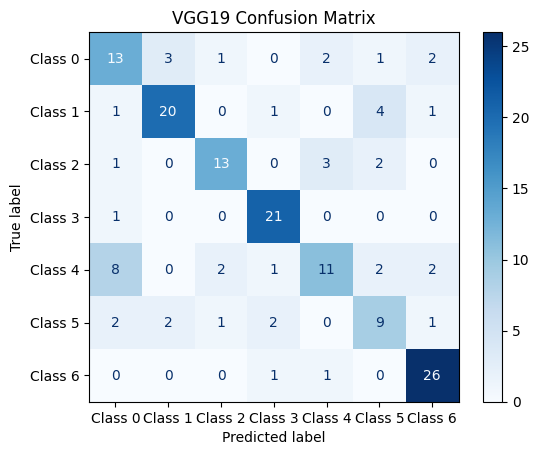

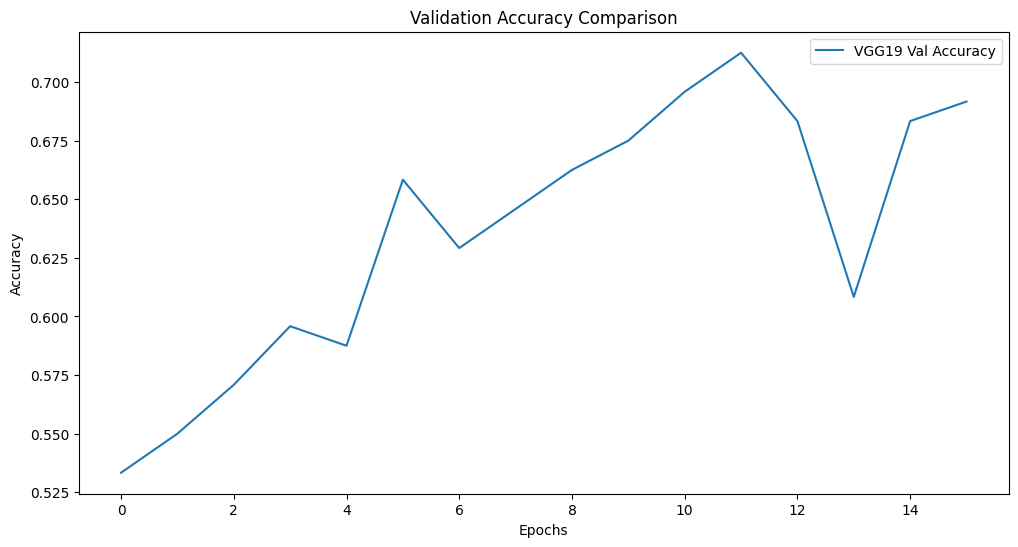

In [ ]:
#!/usr/bin/env python3

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import Image

# ==========================
# GPU CONFIGURATION
# ==========================
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU:", physical_devices[0].name)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# ==========================
# DATA LOADING
# ==========================
dataset_dir = "/content/Speech-Emotion-Recognition/DATASET FINAL"  # Adjust path
emotion_map = {
    "angry": 0,
    "sad": 1,
    "surprise": 2,
    "neutral": 3,
    "happy": 4,
    "fearful": 5,
    "disgust": 6
}

images, labels = [], []

# List all image files in the dataset directory
all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]

# Select a random subset (e.g., 50%) of the dataset
subset_size = int(0.7 * len(all_files))  # Select half of the dataset
selected_files = np.random.choice(all_files, size=subset_size, replace=False)

for file_name in selected_files:
    file_path = os.path.join(dataset_dir, file_name)
    img = Image.open(file_path).convert("RGB").resize((224, 224))
    images.append(np.array(img))

    # Extract emotion label from the filename (e.g., 'CREMA-D_angry_6.png')
    parts = file_name.split("_")
    if len(parts) >= 2:
        emotion = parts[1].lower()  # Extract emotion (e.g., 'angry' from 'CREMA-D_angry_6.png')
        if emotion in emotion_map:
            label_raw = emotion_map[emotion]
        else:
            print(f"Skipping {file_name}: Unknown emotion '{emotion}'.")
            continue
    else:
        print(f"Skipping {file_name}: Incorrect format.")
        continue

    labels.append(label_raw)

images = np.array(images) / 255.0
labels = np.array(labels)

# Number of classes (emotions)
num_classes = len(emotion_map)

labels_one_hot = to_categorical(labels, num_classes=num_classes)
# Split the dataset into 70% for training and 30% for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# ==========================
# DATA AUGMENTATION (COMMENTED OUT)
# ==========================
# data_augmentation = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.3,
#     horizontal_flip=True
# )

# Visualize some augmented images (commented out)
# for x_batch, y_batch in data_augmentation.flow(X_train, y_train, batch_size=9):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         plt.subplot(3, 3, i + 1)
#         plt.imshow(x_batch[i])
#         plt.axis('off')
#     plt.show()
#     break

# ==========================
# MODEL FUNCTIONS
# ==========================
def create_vgg19_model():
    base_model = VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:12]:
        layer.trainable = False
    model = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:50]:
        layer.trainable = False
    model = Sequential([
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# ==========================
# EXPERIMENTAL SETUP
# ==========================
models_to_test = {
    "VGG19": create_vgg19_model,
    # "ResNet50": create_resnet50_model
}

results = {}
for model_name, model_func in models_to_test.items():
    print(f"\nTraining {model_name} model...")
    model = model_func()
    model.compile(optimizer=optimizers.Adam(5e-5),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    callbacks = [
        ModelCheckpoint(f"{model_name}_best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
        ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.95, min_lr=0.000001),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

    history = model.fit(
        # Use original data instead of augmented data (commented out)
        # data_augmentation.flow(X_train, y_train, batch_size=16),
        X_train, y_train,
        epochs=40,
        shuffle=True,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=[f"Class {i}" for i in range(num_classes)]))

    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[f"Class {i}" for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    results[model_name] = {
        "history": history.history,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }

# ==========================
# COMPARATIVE PLOTS
# ==========================
plt.figure(figsize=(12, 6))

for model_name, data in results.items():
    plt.plot(data['history']['val_accuracy'], label=f'{model_name} Val Accuracy')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#!/usr/bin/env python3

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import Image

# GPU Configuration section remains the same...
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU:", physical_devices[0].name)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found. Using CPU.")

# Data Loading section remains the same...
dataset_dir = "/content/Speech-Emotion-Recognition/DATASET FINAL"
emotion_map = {
    "angry": 0,
    "sad": 1,
    "surprise": 2,
    "neutral": 3,
    "happy": 4,
    "fearful": 5,
    "disgust": 6
}

images, labels = [], []
all_files = [f for f in os.listdir(dataset_dir) if f.endswith(".png")]
subset_size = int(0.7 * len(all_files))
selected_files = np.random.choice(all_files, size=subset_size, replace=False)

for file_name in selected_files:
    file_path = os.path.join(dataset_dir, file_name)
    img = Image.open(file_path).convert("RGB").resize((224, 224))
    images.append(np.array(img))

    parts = file_name.split("_")
    if len(parts) >= 2:
        emotion = parts[1].lower()
        if emotion in emotion_map:
            label_raw = emotion_map[emotion]
        else:
            print(f"Skipping {file_name}: Unknown emotion '{emotion}'.")
            continue
    else:
        print(f"Skipping {file_name}: Incorrect format.")
        continue

    labels.append(label_raw)

images = np.array(images) / 255.0
labels = np.array(labels)
num_classes = len(emotion_map)
labels_one_hot = to_categorical(labels, num_classes=num_classes)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

class SpectrogramAugmentation(tf.keras.layers.Layer):
    def __init__(self, max_scale=0.1, **kwargs):
        super(SpectrogramAugmentation, self).__init__(**kwargs)
        self.max_scale = max_scale

    def call(self, inputs, training=None):
        if training:
            batch_size = tf.shape(inputs)[0]

            # Random brightness
            brightness = tf.random.uniform([batch_size], -self.max_scale, self.max_scale)
            x = tf.map_fn(lambda x: x[0] + x[1], (inputs, tf.expand_dims(tf.expand_dims(tf.expand_dims(brightness, -1), -1), -1)), dtype=tf.float32)

            # Random contrast
            contrast = tf.random.uniform([batch_size], 1-self.max_scale, 1+self.max_scale)
            means = tf.reduce_mean(x, axis=[1,2,3], keepdims=True)
            x = tf.map_fn(lambda x: (x[0] - x[1]) * x[2] + x[1],
                         (x, means, tf.expand_dims(tf.expand_dims(tf.expand_dims(contrast, -1), -1), -1)), dtype=tf.float32)

            return tf.clip_by_value(x, 0.0, 1.0)
        return inputs

# Modified Model Functions
def create_vgg19_model():
    base_model = VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:12]:
        layer.trainable = False
    model = Sequential([
        SpectrogramAugmentation(freq_mask_param=20, time_mask_param=20),
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:50]:
        layer.trainable = False
    model = Sequential([
        SpectrogramAugmentation(freq_mask_param=20, time_mask_param=20),
        base_model,
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Rest of the code remains the same...
models_to_test = {
    "VGG19": create_vgg19_model,
    # "ResNet50": create_resnet50_model
}

results = {}
for model_name, model_func in models_to_test.items():
    print(f"\nTraining {model_name} model...")
    model = model_func()
    model.compile(optimizer=optimizers.Adam(5e-5),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    callbacks = [
        ModelCheckpoint(f"{model_name}_best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max"),
        ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.95, min_lr=0.000001),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=40,
        shuffle=True,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=16)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=[f"Class {i}" for i in range(num_classes)]))

    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[f"Class {i}" for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    results[model_name] = {
        "history": history.history,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }

plt.figure(figsize=(12, 6))
for model_name, data in results.items():
    plt.plot(data['history']['val_accuracy'], label=f'{model_name} Val Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Using GPU: /physical_device:GPU:0
Training set: (1600, 224, 224, 3), (1600, 7)
Validation set: (240, 224, 224, 3), (240, 7)
Test set: (161, 224, 224, 3), (161, 7)

Training VGG19 model...


ValueError: Unrecognized keyword arguments passed to SpectrogramAugmentation: {'freq_mask_param': 20, 'time_mask_param': 20}

Using cuda


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:15<00:00, 36.2MB/s]


Epoch: 1/40
Train Loss: 1.7809 | Train Acc: 29.94%
Val Loss: 1.5499 | Val Acc: 48.48%
Epoch: 2/40
Train Loss: 1.5029 | Train Acc: 45.58%
Val Loss: 1.3649 | Val Acc: 53.85%
Epoch: 3/40
Train Loss: 1.3372 | Train Acc: 53.17%
Val Loss: 1.2223 | Val Acc: 61.07%
Epoch: 4/40
Train Loss: 1.2647 | Train Acc: 54.62%
Val Loss: 1.1844 | Val Acc: 59.91%
Epoch: 5/40
Train Loss: 1.2089 | Train Acc: 56.77%
Val Loss: 1.1500 | Val Acc: 62.47%
Epoch: 6/40
Train Loss: 1.1421 | Train Acc: 60.02%
Val Loss: 1.1205 | Val Acc: 60.84%
Epoch: 7/40
Train Loss: 1.0777 | Train Acc: 62.17%
Val Loss: 1.0899 | Val Acc: 59.44%
Epoch: 8/40
Train Loss: 1.0483 | Train Acc: 63.17%
Val Loss: 1.0993 | Val Acc: 59.67%
Epoch: 9/40
Train Loss: 1.0308 | Train Acc: 63.77%
Val Loss: 1.0222 | Val Acc: 62.94%
Epoch: 10/40
Train Loss: 0.9921 | Train Acc: 65.62%
Val Loss: 1.0479 | Val Acc: 60.84%
Epoch: 11/40
Train Loss: 0.9660 | Train Acc: 65.17%
Val Loss: 1.0459 | Val Acc: 64.57%
Epoch: 12/40
Train Loss: 0.9545 | Train Acc: 66.37%


<ipython-input-4-7c810e4ae463>:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Test Loss: 1.0156 | Test Acc: 59.07%


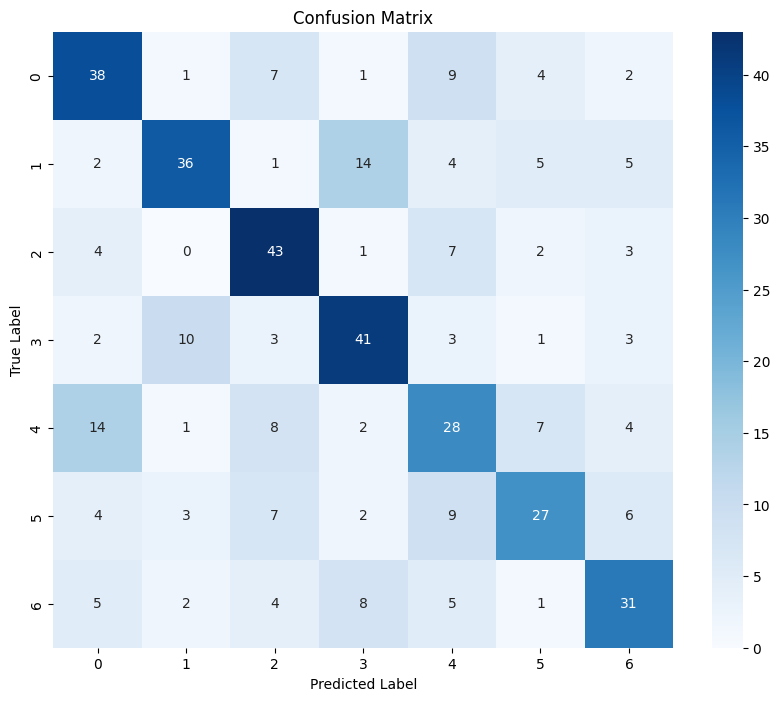

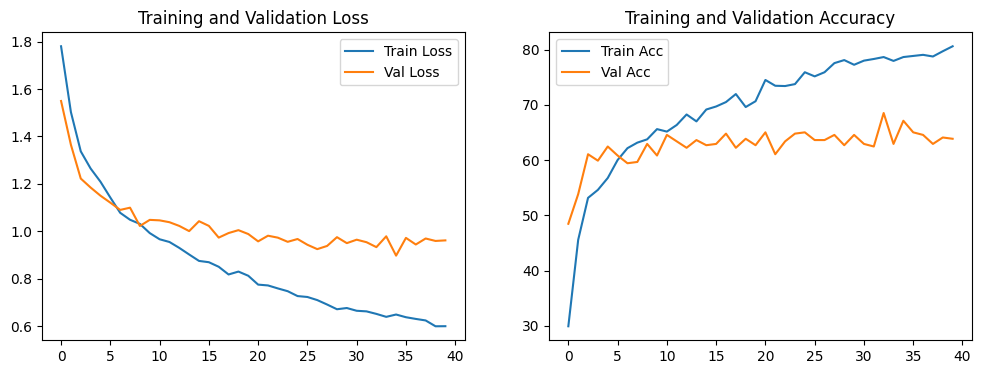

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchaudio.transforms as T
from torchvision import models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# Dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=False):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.emotion_map = {
            "angry": 0, "sad": 1, "surprise": 2, "neutral": 3,
            "happy": 4, "fearful": 5, "disgust": 6
        }

        self.files = [f for f in os.listdir(root_dir) if f.endswith(".png")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        image = Image.open(img_path).convert("RGB")
        image = np.array(image.resize((224, 224))) / 255.0
        image = torch.FloatTensor(image).permute(2, 0, 1)  # HWC to CHW

        emotion = self.files[idx].split("_")[1].lower()
        label = self.emotion_map[emotion]

        if self.train and self.transform:
            image = self.transform(image)

        return image, label

# SpecAugment transformation
class SpecAugmentation:
    def __init__(self, freq_mask_param=30, time_mask_param=30):
        self.freq_mask = T.FrequencyMasking(freq_mask_param)
        self.time_mask = T.TimeMasking(time_mask_param)

    def __call__(self, spec):
        spec = self.freq_mask(spec)
        spec = self.time_mask(spec)
        return spec

# Model definition
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.base_model = models.vgg19(weights='DEFAULT')
        for param in list(self.base_model.parameters())[:-4]:
            param.requires_grad = False

        self.base_model.classifier = nn.Sequential(
            nn.Linear(25088, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss/len(loader), 100.*correct/total

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss/len(loader), 100.*correct/total

# Main training loop
def main():
    # Dataset setup
    transform = SpecAugmentation()
    dataset = SpectrogramDataset("/content/Speech-Emotion-Recognition/DATASET FINAL", transform=transform, train=True)

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Model setup
    model = EmotionCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.95)

    # Training
    epochs = 40
    best_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch: {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

    # Testing
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    print(f'\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

    # Confusion Matrix
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
# Calculate test accuracy for each epoch
test_accuracies = []

for epoch in range(len(history.history['accuracy'])):
    # Recompile the model to use the weights at this epoch
    model.set_weights(history.model.get_weights())

    # Evaluate on test set
    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_accuracies.append(test_accuracy)

# Plot validation and test accuracies
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.plot(test_accuracies, label="Test Accuracy", linestyle="--")
plt.title(f"Validation and Test Accuracy for {model_name}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


NameError: name 'history' is not defined

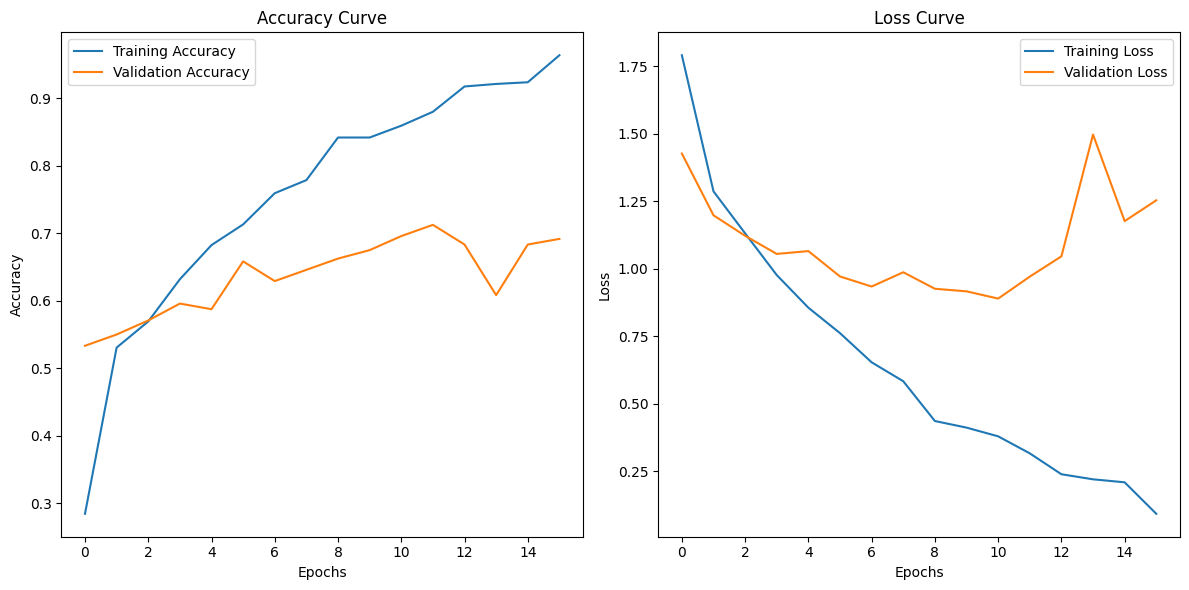

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.50      0.59      0.54        22
         sad       0.80      0.74      0.77        27
    surprise       0.76      0.68      0.72        19
     neutral       0.81      0.95      0.88        22
       happy       0.65      0.42      0.51        26
     fearful       0.50      0.53      0.51        17
     disgust       0.81      0.93      0.87        28

    accuracy                           0.70       161
   macro avg       0.69      0.69      0.69       161
weighted avg       0.70      0.70      0.70       161



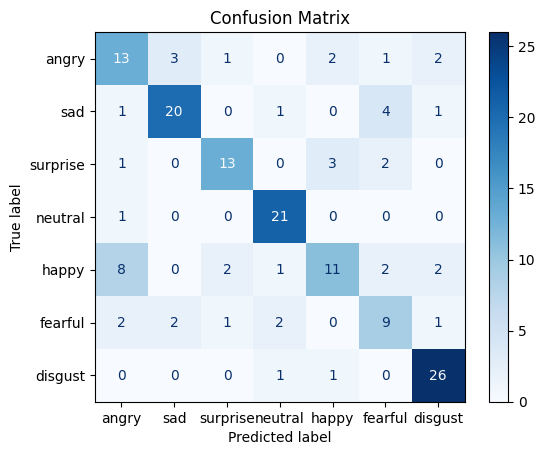

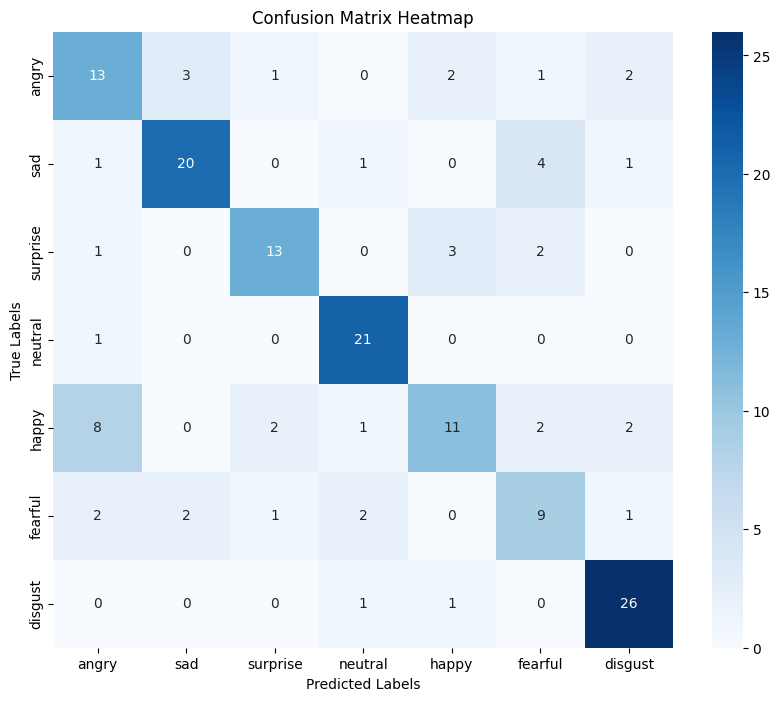

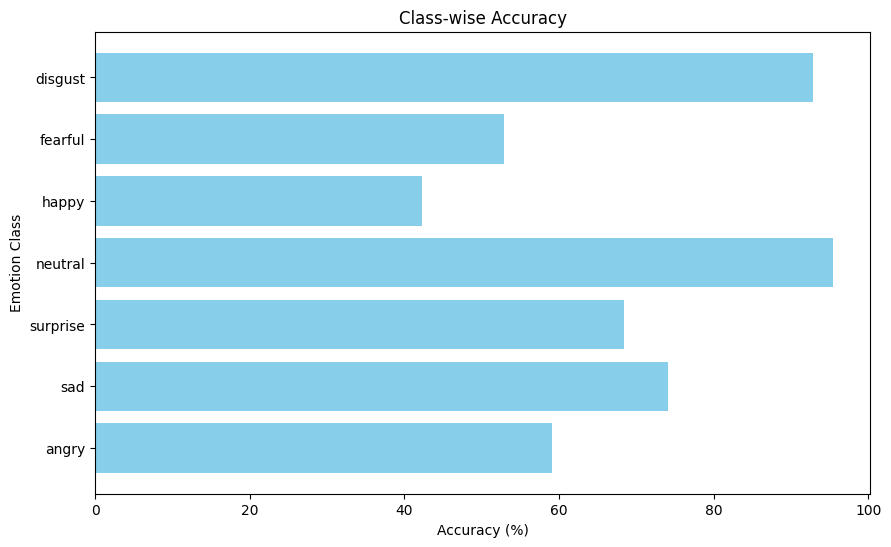

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ==========================
# PLOTS OF TRAINING HISTORY
# ==========================
plt.figure(figsize=(12, 6))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ==========================
# CONFUSION MATRIX AND CLASSIFICATION REPORT
# ==========================
# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot predictions to class indices
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
emotion_labels = list(emotion_map.keys())  # Emotion labels in string format
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=emotion_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ==========================
# VISUALIZATION OF CONFUSION MATRIX WITH HEATMAP
# ==========================
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ==========================
# CLASS-WISE ACCURACY PLOT
# ==========================
# Calculate class-wise accuracy
class_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1) * 100
plt.figure(figsize=(10, 6))
plt.barh(emotion_labels, class_accuracy, color='skyblue')
plt.title("Class-wise Accuracy")
plt.xlabel("Accuracy (%)")
plt.ylabel("Emotion Class")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Initialisation des dictionnaires pour stocker les métriques
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Parcours des résultats pour calculer les métriques par modèle
for model_name, data in results.items():
    # Extraire les prédictions et les vraies classes
    y_pred = model.predict(X_test)  # Prédictions pour le test set
    y_pred_classes = np.argmax(y_pred, axis=1)  # Classes prédites
    y_true_classes = np.argmax(y_test, axis=1)  # Vraies classes

    # Calculer les métriques pour chaque classe
    report = classification_report(y_true_classes, y_pred_classes, output_dict=True)

    # Extraire les scores de précision, rappel et F1 pour chaque classe
    precision_scores[model_name] = [report[str(i)]['precision'] for i in range(num_classes)]
    recall_scores[model_name] = [report[str(i)]['recall'] for i in range(num_classes)]
    f1_scores[model_name] = [report[str(i)]['f1-score'] for i in range(num_classes)]

# Tracer les métriques pour chaque classe et chaque modèle

x = np.arange(num_classes)  # Positions des classes sur l'axe des x
width = 0.25  # Largeur des barres pour chaque modèle

fig, ax = plt.subplots(figsize=(12, 6))

# Tracer les barres pour chaque modèle et chaque métrique
for i, model_name in enumerate(results.keys()):
    ax.bar(x - width + i * width, precision_scores[model_name], width, label=f'{model_name} Precision')
    ax.bar(x - width + i * width, recall_scores[model_name], width, label=f'{model_name} Recall', alpha=0.7)
    ax.bar(x - width + i * width, f1_scores[model_name], width, label=f'{model_name} F1-Score', alpha=0.7)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision, Recall, and F1-Score by Model and Class')
ax.set_xticks(x)
ax.set_xticklabels([f'Class {i}' for i in range(num_classes)])
ax.legend()

plt.tight_layout()
plt.show()


NameError: name 'results' is not defined

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


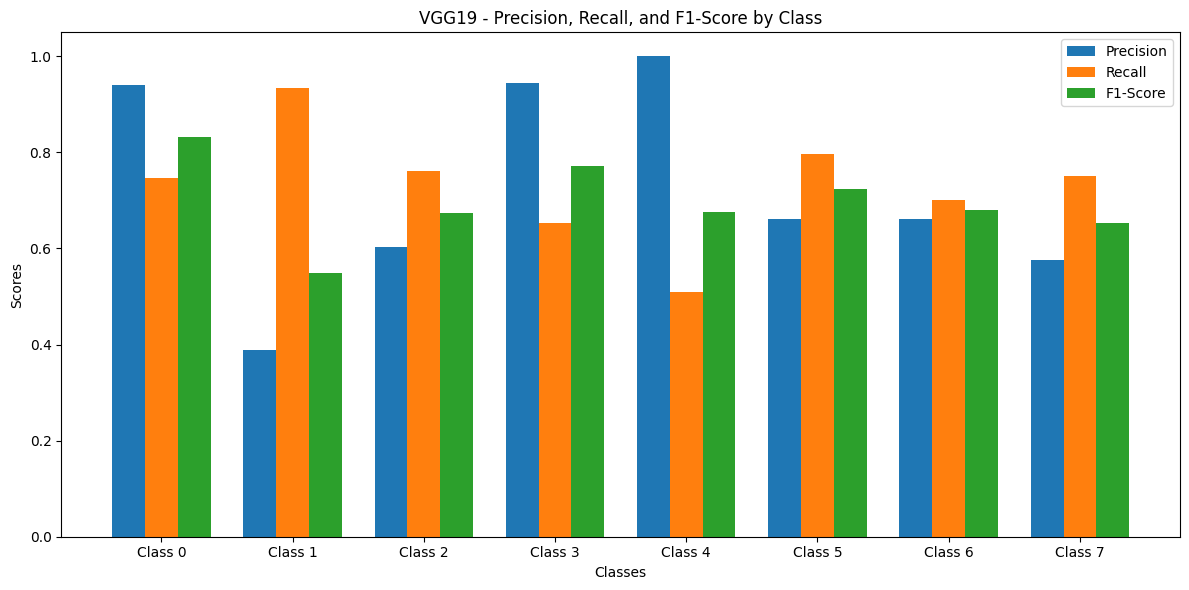

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Spécifiez le nom du modèle que vous voulez afficher (par exemple, "VGG19" ou "ResNet50")
model_name = "VGG19"  # Changez ici pour le modèle que vous souhaitez analyser

# Extraire les prédictions et les vraies classes
y_pred = model.predict(X_test)  # Prédictions pour le test set
y_pred_classes = np.argmax(y_pred, axis=1)  # Classes prédites
y_true_classes = np.argmax(y_test, axis=1)  # Vraies classes

# Calculer les métriques pour chaque classe
report = classification_report(y_true_classes, y_pred_classes, output_dict=True)

# Extraire les scores de précision, rappel et F1 pour chaque classe
precision_scores = [report[str(i)]['precision'] for i in range(num_classes)]
recall_scores = [report[str(i)]['recall'] for i in range(num_classes)]
f1_scores = [report[str(i)]['f1-score'] for i in range(num_classes)]

# Positions des classes sur l'axe des x
x = np.arange(num_classes)
width = 0.25  # Largeur des barres

# Graphique pour la précision, rappel et F1-score sur le même graphique
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer la précision, rappel et F1-score
ax.bar(x - width, precision_scores, width, label='Precision')
ax.bar(x, recall_scores, width, label='Recall')
ax.bar(x + width, f1_scores, width, label='F1-Score')

# Personnaliser l'affichage
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title(f'{model_name} - Precision, Recall, and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels([f'Class {i}' for i in range(num_classes)])
ax.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()
